# LeNet-5 Model implementation


This is the trainning and testin of the LeNet5 model given in  (http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)
using tensorflow




In [1]:
import os 
__file__=os.getcwd()
from os.path import dirname, abspath
d = dirname(abspath(__file__))
os.chdir(d)
os.getcwd()

'C:\\Users\\LinaMaria\\Desktop\\JUAN MANUEL\\Machine learning\\German Traffic Signs Detector\\German-Traffic-Signs-Detector'

In [2]:
import urllib.request
import os
from sklearn.model_selection import train_test_split
from linearRegTrain import SCReg
from linearRegTrain import SCEval
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2 
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

defining some functions to evaluate the CNN

In [3]:
def evaluate(x,y,accuracy_operation,sess,X_data, y_data, BATCH_SIZE=64):
    """A FUNCTION TO EVALUATE THE ACCURACY OF THE CNN IN THE TRAINNING DATA
    INPUTS 
    1. x tfplace holder size(?,32,32,1)
    2. y tfplace holder size(?)
    3.accuracy_operation ---->the operation in the NN to determine wheter a N fails 
    4.X_data np.array(Nimages,32,32,1)
    5 y_data list of len (Nimages) 
    6.BATCH_SIZE size of the batch to evaluate the accuracy
    
    OUTPUT 
    1 total_accuracy / num_examples IT IT THE ACCURACY OF THE NN
    
    
    OUTPUT
    """
#    print(X_data[0:64],y_data[0:64])
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
#    print(X_data.shape)
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy=sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [4]:
def getImagesAndLabels(DirectoryToSearch, TypeOfImage=1,IsCNN=True):
    """
   #################
   ### INPUTS ----------------1. DirectoryToSearch : A FOLDER IN ANY FOLDER OR SUBFOLDER OF THE
                              2. TypeOfImage 0 ----for test 1--- for train 2 for infer
   CURRENT WORKING DIRECTORY WHERE THERE ARE IMAGES.PPM
   
   #### OUTPUTS
   1 xImages:----------->numpy array size(nImages,32,32,1) 1 channel because images are grayscale
   2 Y_labels-----------> list with int class labels of len nImages
   ####A
   """
    new_wd=os.getcwd();
    os.chdir(new_wd)
    ## looking for DirectoryToSearch in path
    if os.path.exists(DirectoryToSearch) :
        files_Taken=os.listdir(DirectoryToSearch)
        files_Taken = [file for file in files_Taken if file.endswith("ppm")]
        trainFolder=DirectoryToSearch
    elif os.path.exists(os.getcwd()+DirectoryToSearch):
#        for root, dirs, files in os.walk(os.getcwd()):
#            if DirectoryToSearch in dirs:
#                trainFolder=os.path.join(root, DirectoryToSearch)
#                print('the path to the images and labels is '+trainFolder)
        trainFolder=os.getcwd()+DirectoryToSearch
        files_Taken =os.listdir(trainFolder)
        files_Taken = [file for file in files_Taken if file.endswith("ppm")]
    else:
        if(TypeOfImage==1):
            DirectoryToSearch='/images/train'
            print('\n INVALID DIRECTORY:\n taking files from images/train folder to avoid errors in training type "python app.py train --help" to avoid this error again\n\n\n')
        elif(TypeOfImage==0):
            DirectoryToSearch='/images/test'
            print('\n INVALID DIRECTORY:\n taking files from images/test folder to avoid errors in testing type "python app.py test --help" to avoid this error again\n\n\n')
        elif(TypeOfImage==2):
            DirectoryToSearch='/images/user'
            print('\n INVALID DIRECTORY:\n taking files from images/user folder to avoid errors in infering type "python app.py test --help" to avoid this error again\n\n\n')
            
        trainFolder=os.getcwd()+DirectoryToSearch
        files_Taken =os.listdir(trainFolder)
        files_Taken = [file for file in files_Taken if file.endswith("ppm")]
     ### creating a tensor for the Images and the labels in the model
    if len(files_Taken)==0:
        print('there arent any images to train the model')
    Y_labels=list()
    numbImages=len(files_Taken)
    ### creating a matrix
    xImages=np.zeros(shape=(numbImages,32,32))
    count=0
    ### RESIZING THE IMAGES TO 32.32 AND APPLYING GRAYSCALE FILTER
    for filename in files_Taken:
        im = Image.open(trainFolder+'/'+filename)
        im = im.convert("L")
        im=np.array(im)
        final=cv2.resize(im,(32,32))
        final = cv2.equalizeHist(final)
        final=np.divide(final, 255)
        xImages[count]=final
        
        if(TypeOfImage==2):
            Y_labels.append(filename)
        else:
            Y_labels.append(int(filename[:2]))
        count+=1
    xImages=xImages.reshape((numbImages,32,32,1))
    if(TypeOfImage==2):
        return xImages,Y_labels,trainFolder
    return xImages,Y_labels

In [ ]:
# CNN architecture

As seen in the paper the LeNet 5 Accepts 32,32 images with 1 channel in this case grayscale,
this input image is going to be feeded to the placeholder X. the None dimension coincides with the number of images given.


Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.


Layer 1:This is a convolutional layer. The output shape should be 28x28x6. this is because the stride is one in each dimension 
    and the padding parameter is set as padding, this doesnt allow overlapping

Activation. Your choice of activation function.

Pooling. The output shape should be 14x14x6.

Layer 2: Convolutional. The output shape should be 10x10x16.

Activation. Your choice of activation function.

Pooling. The output shape should be 5x5x16.

Flatten. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

Layer 3: Fully Connected. This should have 120 outputs.

Activation. Your choice of activation function.

Layer 4: Fully Connected. This should have 84 outputs.

Activation. Your choice of activation function.

Layer 5: Fully Connected (Logits). This should have 10 outputs.

Output
Return the result of the 2nd fully connected layer.

In [9]:
def TrainAndSave(pathToSave=os.getcwd()+'/models/model3/saved/',mu=0.0,sigma=0.1,EPOCHS=50,BATCH_SIZE=64,Directory_Train='/images/train'):
    """
   **. INPUTS 
   1.pathToSave------------->DEFAULT PATH  REPOSITORY_WD/models/model3/saved/'
   2. mu -----------------> MEAN OF THE TRUNCATED NORMAL DIST
   3. SIGMA -----------------> DEVIATION OF THE TRUNCATED NORMAL DIST
   4.BATCH_SIZE-------------->SIZE OF THE BATCH FOR TRAINING TO AVOID LOCAL MINIMA
   5.Directory_Train----------> BY DEFAULT IS THE TRAIN FOLDER...
   ...IT CAN ALSO BE GIVEN AS A GLOBAL PATH C:\\USERS'\\...
   ***OUTPUTS
   THE CNN MODEL SAVED AT 'pathToSave' LOCATION
    """

#    Directory_Train='train'
    print(Directory_Train)
    X_train,Y_train=getImagesAndLabels(Directory_Train)
    """
    ##Defining the graph
    #####
    #####################
    #####################
    the details are in the jupyter notebook
    """

    g = tf.Graph()
    with g.as_default():
        n_out=43
        x = tf.placeholder(tf.float32, (None, 32, 32, 1),name='X')
        y = tf.placeholder(tf.int32, (None),name="Y")
        filter1_width = 5
        filter1_height = 5
        input1_channels = 1
        learning_rate=0.0009
        conv1_output = 6
        conv1_weight = tf.Variable(tf.truncated_normal(
            shape=(filter1_width,filter1_height, input1_channels, conv1_output),mean = mu, stddev =sigma),name='w1')
        conv1_bias = tf.Variable(tf.zeros(conv1_output),name='b1')
        conv1 = tf.nn.conv2d(x,conv1_weight, strides=[1, 1, 1, 1], padding='VALID',name='conv10') + conv1_bias
        conv1 = tf.nn.relu(conv1,name='conv11')
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID',name='conv1')
        filter2_width = 5
        filter2_height = 5
        input2_channels = 6
        conv2_output = 16
        conv2_weight = tf.Variable(tf.truncated_normal(
            shape=(filter2_width, filter2_height, input2_channels, conv2_output),
            mean = mu, stddev = sigma))
        conv2_bias = tf.Variable(tf.zeros(conv2_output))
        conv2 = tf.nn.conv2d(conv1,conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + conv2_bias
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        fully_connected0 = flatten(conv2)
        connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
        connected1_bias = tf.Variable(tf.zeros(120))
        fully_connected1 = tf.add((tf.matmul(fully_connected0, connected1_weights)), connected1_bias)
        fully_connected1 = tf.nn.relu(fully_connected1)
        # Layer  (Fully Connected): Input = 120. Output = 84.
        connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
        connected2_bias = tf.Variable(tf.zeros(84))
        fully_connected2 = tf.add((tf.matmul(fully_connected1, connected2_weights)), connected2_bias,name='FC2')
        fully_connected2 = tf.nn.relu(fully_connected2)
        # Layer 5 (Fully Connected): Input = 84. Output = 43.
        output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
        output_bias = tf.Variable(tf.zeros(43),name='finalbias')
        logits =  tf.add(tf.matmul(fully_connected2, output_weights), output_bias,name='logits')
        one_hot_y = tf.one_hot(y, n_out)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
        loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        training_operation = optimizer.minimize(loss_operation)
        # Accuracy operation
        ### Returns the truth value of (x == y) element-wise.
        ##is argmax(logits) equal to y?
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1),name='correct')
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracyOp')
        saver = tf.train.Saver()
    ##TRAINING the graph
    #####################
    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        num_samples = len(Y_train)
        print("Training ...\n")
        for i in range(EPOCHS):
            shuffled_images, y_train = shuffle(X_train, Y_train)
            for offset in range(0, num_samples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = shuffled_images[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
    #  IF  DROPOUT is required        sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})
        validation_accuracy = evaluate(x,y,accuracy_operation,sess,X_train, Y_train)
    #IN CASE VALIDATION ON TEST DATA         validation_accuracy2 = evaluate(X_test, ytest)
        print("FINAL RESULT AT EPOCH # {} : Validation Accuracy = {:.2f}%".format(i+1, (validation_accuracy*100)))
    #IN CASE VALIDATION ON TEST DATA        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy2*100)))
        saver.save(sess,pathToSave)
#        print("Model saved")
    return

In [10]:
TrainAndSave()

/images/train
Training ...

FINAL RESULT AT EPOCH # 50 : Validation Accuracy = 100.00%


In [16]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#from LeNet5 import getImagesAndLabels
import LeNet5
import GetImages

# CNN architecture

As seen in the paper the LeNet 5 Accepts 32,32 images with 1 channel in this case grayscale,
this input image is going to be feeded to the placeholder

Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

Architecture
Layer 1: Convolutional. The output shape should be 28x28x6.

Activation. Your choice of activation function.

Pooling. The output shape should be 14x14x6.

Layer 2: Convolutional. The output shape should be 10x10x16.

Activation. Your choice of activation function.

Pooling. The output shape should be 5x5x16.

Flatten. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

Layer 3: Fully Connected. This should have 120 outputs.

Activation. Your choice of activation function.

Layer 4: Fully Connected. This should have 84 outputs.

Activation. Your choice of activation function.

Layer 5: Fully Connected (Logits). This should have 10 outputs.

Output
Return the result of the 2nd fully connected layer.

In [17]:
def evaluate(X,Y,acOp,X_data, y_data, BATCH_SIZE=64):
    """A FUNCTION TO EVALUATE THE ACCURACY OF THE CNN IN THE TRAINNING DATA
    INPUTS 
    1. x tfplace holder size(?,32,32,1)
    2. y tfplace holder size(?)
    3.accuracy_operation ---->the operation in the NN to determine wheter a N fails 
    4.X_data np.array(Nimages,32,32,1)
    5 y_data list of len (Nimages) 
    6.BATCH_SIZE size of the batch to evaluate the accuracy
    
    OUTPUT 
    1 total_accuracy / num_examples IT IT THE ACCURACY OF THE NN
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
#        accuracy = sess.run(accuracy_operation, 
#                            feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
        accuracy=sess.run(acOp, feed_dict={X: batch_x, Y: batch_y})


        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
    
    


In [18]:
def testLeNet5(Directory_Test='/images/test' ,ModelPath='/models/model3/saved/'):
    """
    A function that loads the lenet5 model located in ModelPath 
    and uses it test the images in the Directory_Test
    INPUTS
    1.Directory_Test---> Directory to the images for testing
    2.ModelPath---------> the directory to load the tf graph
    OUTPUT.
    IT PRINTS THE ACCURACY OF THE MODEL IN THE TESTING IMAGES
    
    
    """
    TypeOfImage=0
    X_test,Y_test=LeNet5.getImagesAndLabels(Directory_Test,TypeOfImage)
    with tf.Session() as sess:   
        loader = tf.train.import_meta_graph(os.getcwd()+ModelPath+'.meta')
        loader.restore(sess, tf.train.latest_checkpoint(os.getcwd()+ModelPath))
        graph = tf.get_default_graph()
        X=graph.get_tensor_by_name("X:0")
        Y=graph.get_tensor_by_name("Y:0")
        acOp=graph.get_tensor_by_name("accuracyOp:0")
        validation_accuracy=evaluate(X,Y,acOp,X_test, Y_test, BATCH_SIZE=64)
        print("\n\nTest Accuracy = {:.2f}%".format( (validation_accuracy*100)))
    return

In [21]:
def inferLeNet5(Directory_infer='/images/user' ,ModelPath='/models/model3/saved/'):
    """
    A function that loads the lenet5 model located in ModelPath 
    and uses it test the images in the Directory_infer folder 
    INPUTS
    1.Directory_infer---> Directory to the images that will be classified
    2.ModelPath---------> the directory to load the tf graph
    OUTPUT.
    IT OPENS A PLT PLOT WINDOW WITH THE ORIGINAL IMAGE AND THE OUTPUT CLASS
    """
    TypeOfImage=2
    X_test,Y_test,inferFolder=LeNet5.getImagesAndLabels(Directory_infer,TypeOfImage)
    with tf.Session() as sess:   
        loader = tf.train.import_meta_graph(os.getcwd()+ModelPath+'.meta')
        loader.restore(sess, tf.train.latest_checkpoint(os.getcwd()+ModelPath))
        graph = tf.get_default_graph()
        X=graph.get_tensor_by_name("X:0")
        Logits=graph.get_tensor_by_name("logits:0")
        cont=0
        DictClasses=GetImages.getDictClasses()
        for i in X_test:
            i=i.reshape(1,32,32,1)
            Proba=sess.run(Logits, feed_dict={X: i})
            plt.figure(str(Y_test[cont])+'   '+str(np.argmax(Proba,1)))
            im = Image.open(inferFolder+'/'+Y_test[cont])
            plt.text(-1,-1,'file'+Y_test[cont]+'   belongs to class '+DictClasses[int(np.argmax(Proba,1))])
            plt.imshow(im,vmin = 0, vmax = 255)
#            plt.imshow(i[0,:,:,0],cmap='gray', vmin = 0, vmax = 1)
#                plt.show()
            cont=cont+1
    plt.show()
    return

In [20]:
testLeNet5()

INFO:tensorflow:Restoring parameters from C:\Users\LinaMaria\Desktop\JUAN MANUEL\Machine learning\German Traffic Signs Detector\German-Traffic-Signs-Detector/models/model3/saved/


Test Accuracy = 91.36%


INFO:tensorflow:Restoring parameters from C:\Users\LinaMaria\Desktop\JUAN MANUEL\Machine learning\German Traffic Signs Detector\German-Traffic-Signs-Detector/models/model3/saved/


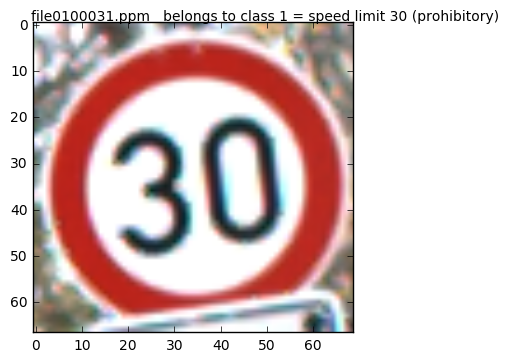

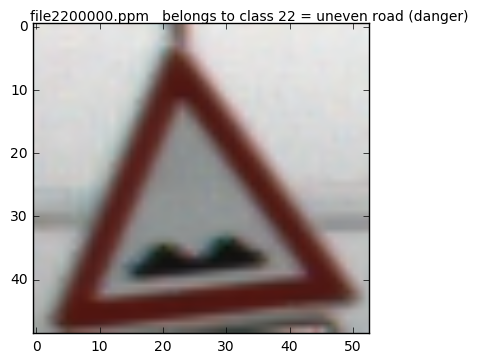

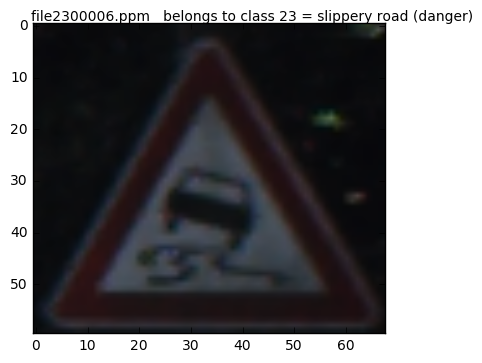

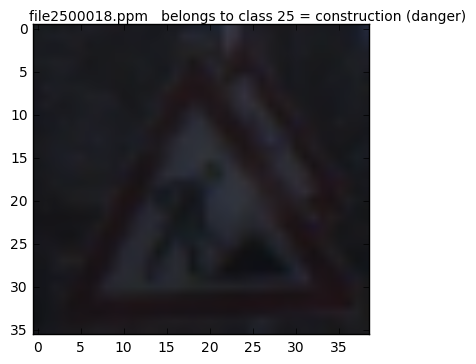

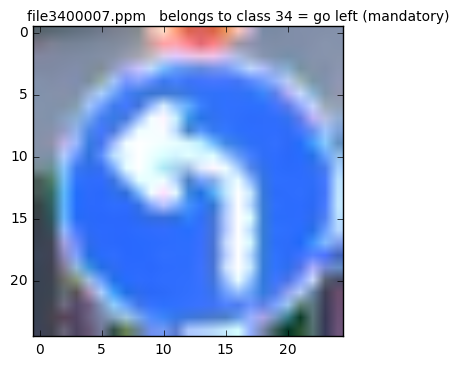

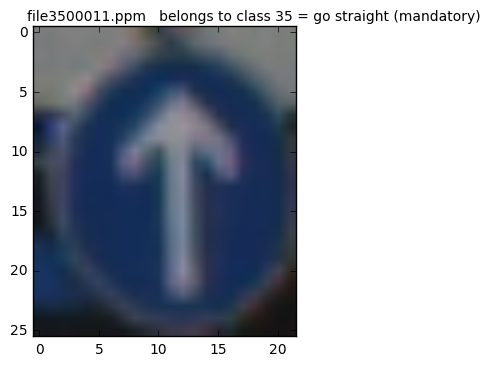

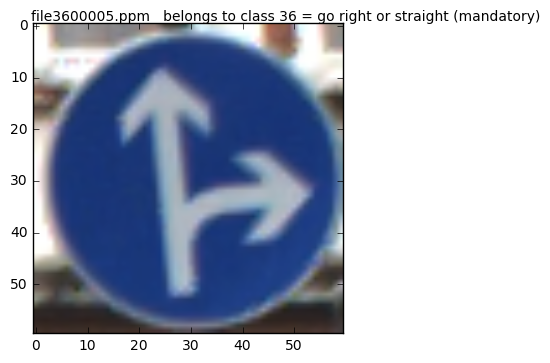

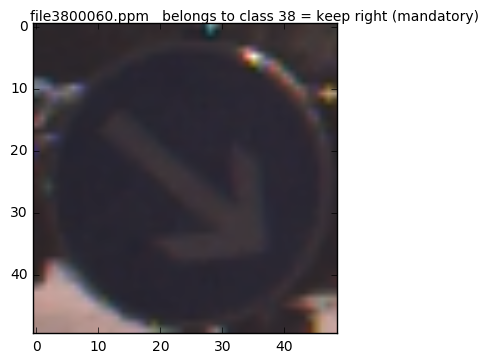

In [22]:
inferLeNet5()

# This model got an accuracy on 100% in validation data, and it was able to predict the class '22:uneven road' to the file2200000.ppm.
These are the adventages of the convolution.
This image was a problem for the others classifiers maybe because of the rotation. but the CNNs have god invariance to rotations and scale operations